# Accessibility to Public Services: Ecuador Case

In [1]:
import geopandas as gpd #Para archivos .shp 
import matplotlib.pyplot as plt #Para gráficar 
#Se define el tamaño de salidad de las gráficas

import numpy as np 
import pandas as pd

from shapely import wkt
import geopy.distance
from math import radians, cos, sin, asin, sqrt

from pandas.core.frame import DataFrame
from functools import reduce
import pyproj as pp
from pyproj import Proj


from pylab import rcParams 
rcParams['figure.figsize'] = 30,30

import warnings
warnings.filterwarnings('ignore')

## Handle spatial data of beneficiaries of non-contributory monetary transfers in Quito - MIES

In [3]:
#Database from MIES

# BDH and others pensions 
df_1 = pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/bonos_pensiones_ago2023.xlsx", sheet_name= "PARTE 1 AGO2023",dtype={'dpa_prov': str})
df_2 = pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2023/bonos_pensiones_ago2023.xlsx", sheet_name= "PARTE 2 AGO2023")
df_MIES = pd.concat([df_1, df_2], ignore_index=True)


df_ben = df_MIES.groupby(['dpa_desprov','beneficio'])['beneficio'].count().reset_index(name='Total_beneficiarios')
df_ben




,dpa_desprov,beneficio,Total_beneficiarios
0,AZUAY,BONO 1000 DIAS,1731
1,AZUAY,BONO DE DESARROLLO HUMANO,25914
2,AZUAY,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,8903
3,AZUAY,BONO JOAQUIN GALLEGOS LARA,1280
4,AZUAY,PENSION MIS MEJORES AÑOS,14056
...,...,...,...
193,ZONA EN ESTUDIO,BONO DE DESARROLLO HUMANO CON COMPONENTE VARIABLE,427
194,ZONA EN ESTUDIO,PENSION MIS MEJORES AÑOS,423
195,ZONA EN ESTUDIO,PENSION PARA ADULTOS MAYORES,1
196,ZONA EN ESTUDIO,PENSION PARA PERSONAS CON DISCAPACIDAD,1


<Axes: >

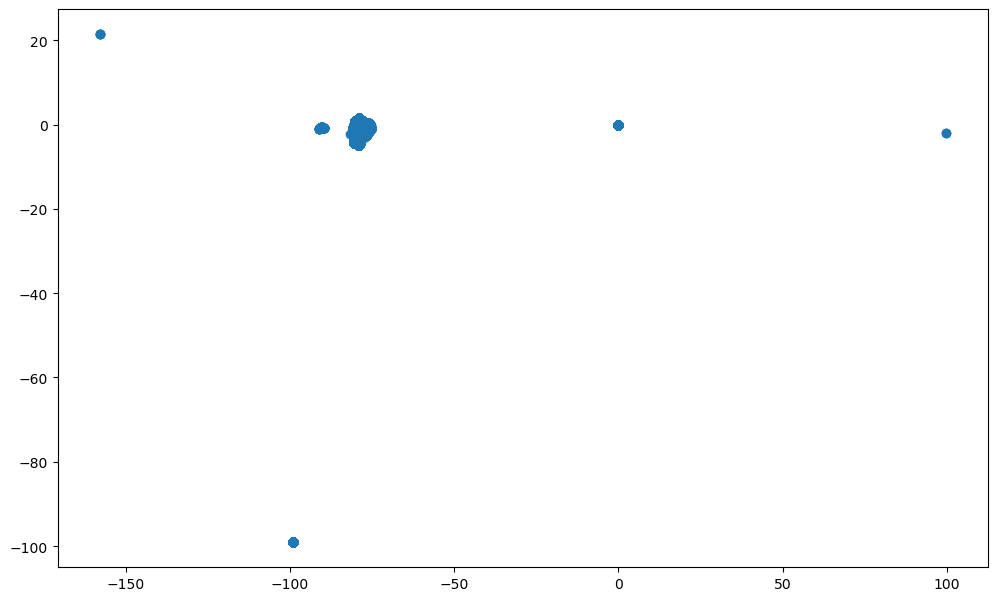

In [3]:
# Convert  MIES´s Database to spatial format "EPSG:4326"

df_MIES.dropna(subset=['x', 'y'], inplace= True)

df_MIES_gdf= gpd.GeoDataFrame(df_MIES, geometry= gpd.points_from_xy(df_MIES['x'],df_MIES['y']))
df_MIES_gdf['geometry'] = df_MIES_gdf['geometry'].astype(str).apply(wkt.loads)
gdf_hog = gpd.GeoDataFrame(df_MIES_gdf)

gdf_hog = gdf_hog.set_crs("EPSG:4326")
gdf_hog.plot()

Because the MIES points have wrong geographical points (points that are outside Ecuador), the following steps are performed:

1. The shapefile of the provinces of Ecuador is loaded and converted into the 4326 format (same geographic format as the MIES base)

In [4]:
df_prov= gpd.read_file("../data/Ecuador_porprovincias/ecuador.shp",encoding='ISO-8859-1') #Se lee la base de datos .Shp
df_prov = df_prov.to_crs("EPSG:4326")

2. Interception between beneficiaries of non-contributory monetary transfers and ecuadorian provinces shapefile.


In [5]:
df_final = gpd.sjoin(gdf_hog,df_prov,how='left')
df_final.head(2)

,zon_plan,uni_des_mi,dpa_prov,dpa_desprov,dpa_can,dpa_descan,dpa_par,dpa_despar,beneficio,edad,...,OBJECTID,DPA_PROVIN,DPA_DESPRO,DPA_VALOR,DPA_ANIO,REI_CODIGO,REN_CODIGO,PEE_CODIGO,Shape_Leng,Shape_Area
0,Zona Planificación 6,UNIDAD DESCONCENTRADA ZONAL 6,1,AZUAY,108,SANTA ISABEL,10851,ABDON CALDERON (LA UNION),PENSION MIS MEJORES AÑOS,74.0,...,1.0,01,AZUAY,0.0,2010,05,01,593,679651.580798,8.325642e+09
1,Zona Planificación 6,UNIDAD DESCONCENTRADA ZONAL 6,1,AZUAY,101,CUENCA,10150,CUENCA,PENSION PARA ADULTOS MAYORES,82.0,...,1.0,01,AZUAY,0.0,2010,05,01,593,679651.580798,8.325642e+09


3. The points that are outside of Ecuador are eliminated

<Axes: >

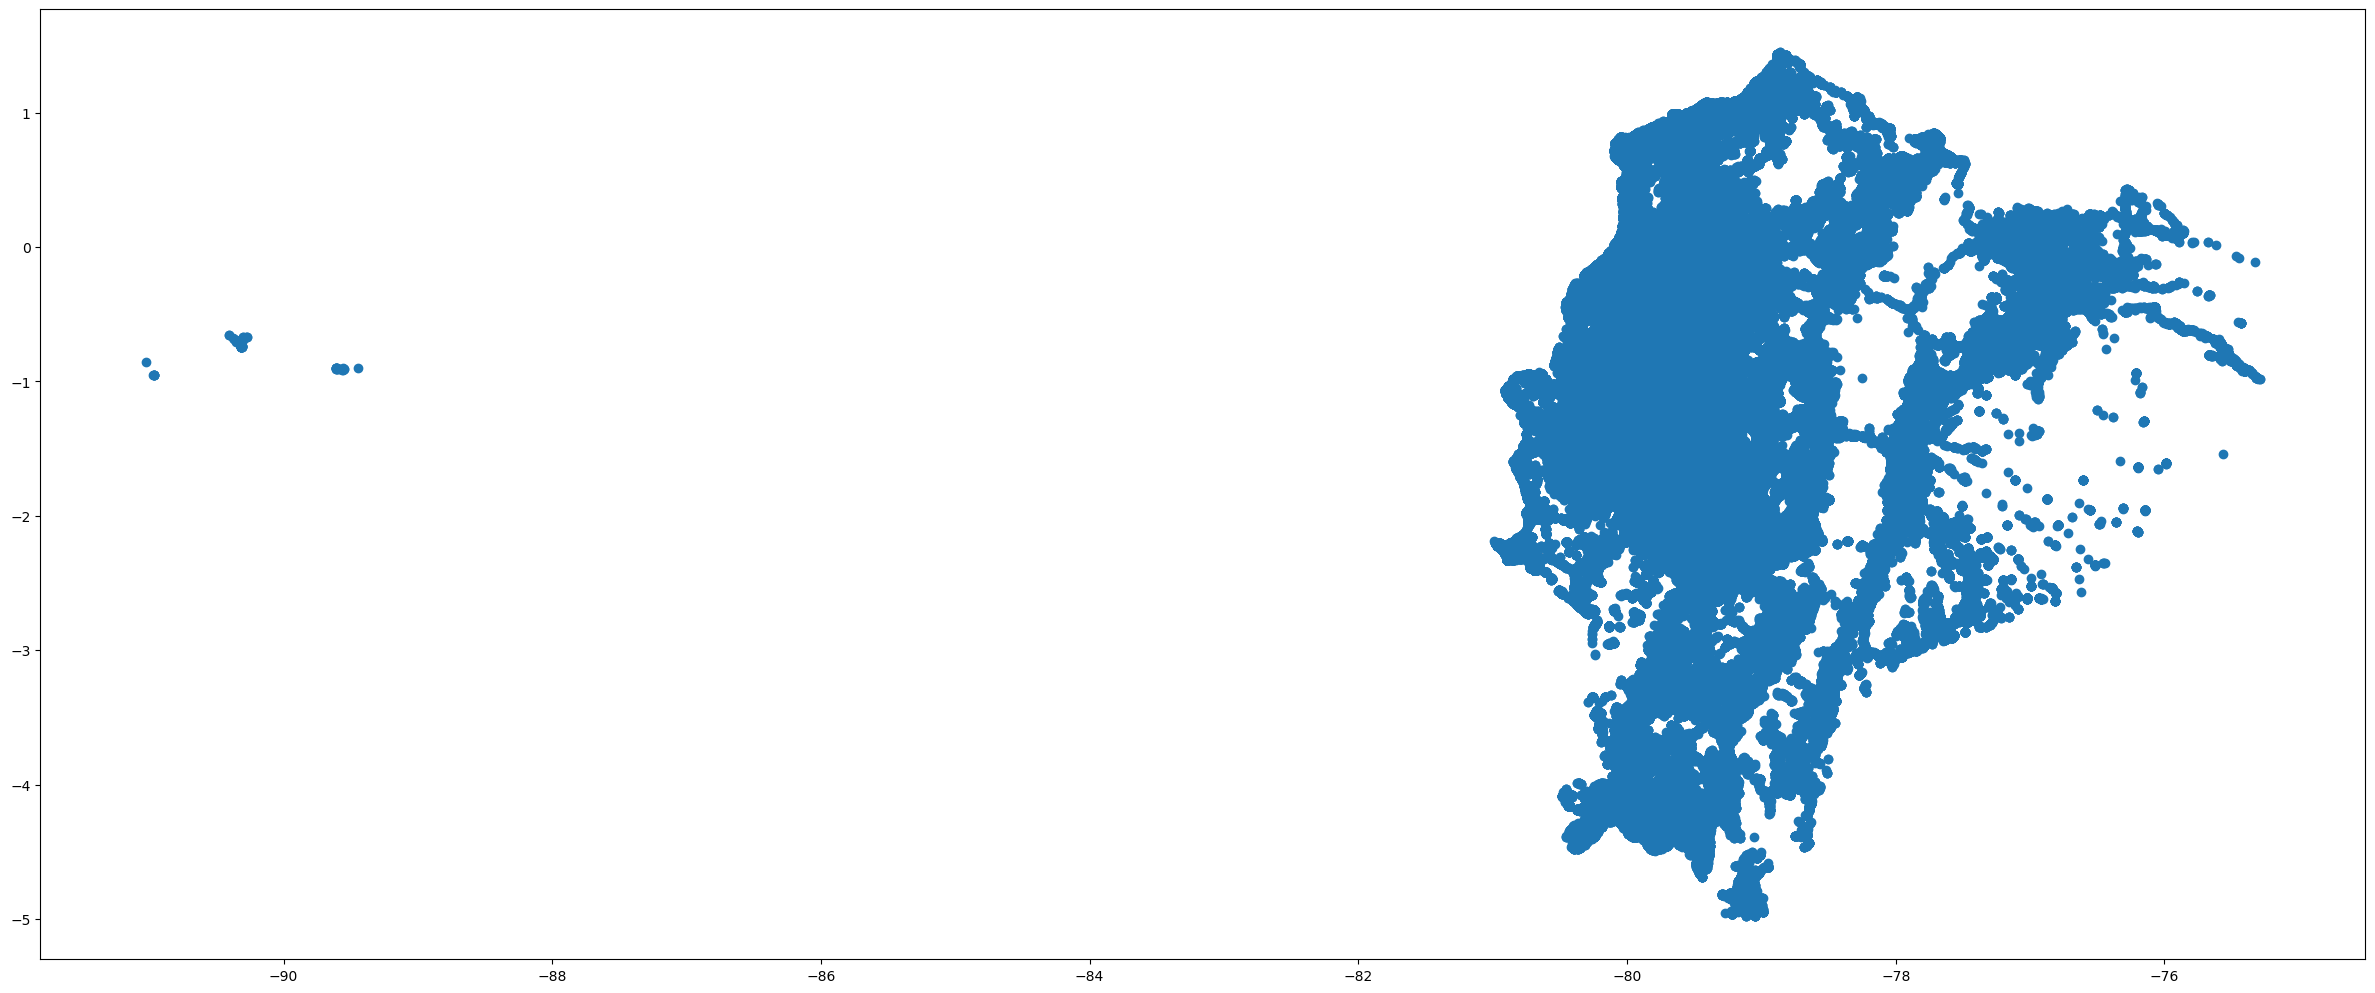

In [29]:
df_final.dropna(subset=['DPA_DESPRO'], inplace = True )
df_final.plot()

In [7]:
df_final = df_final[['DPA_PROVIN','DPA_DESPRO','beneficio','edad','geometry']]

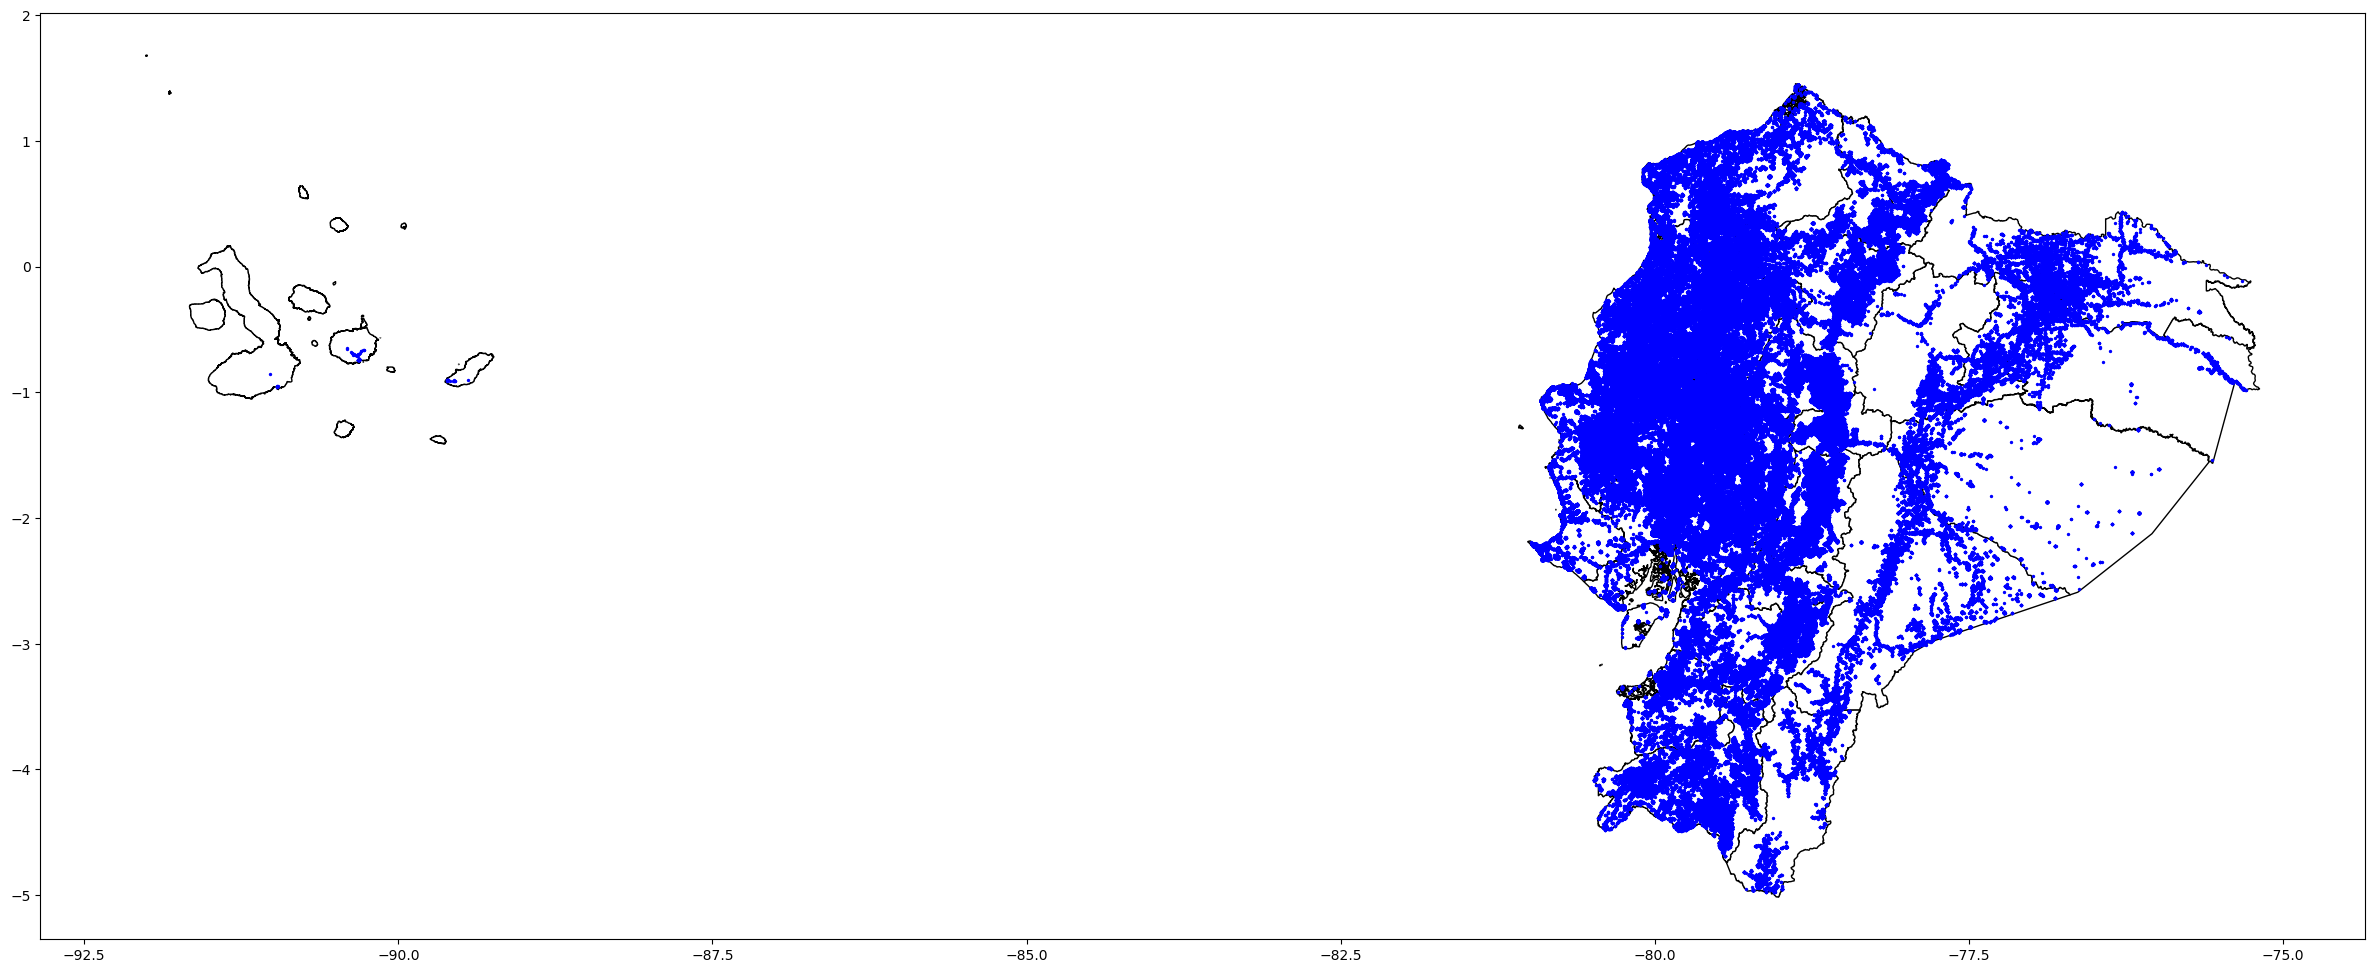

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_aspect('equal')
df_prov.plot(ax=ax, color='white', edgecolor='black')
df_final.plot(ax=ax, marker='o', color='blue', markersize=2)

plt.show()

# Social services center. 



In [11]:
#Database from MIES
#Ubicación de los centros de MIES
df_mies_c= pd.read_excel("https://info.inclusion.gob.ec/images/usuarios_externos/2022/UNIDADES_INCLUSION_SOCIAL_JUL2022.xls")

df_mies_c.dropna(subset=['x'], inplace = True )

In [12]:
#Reproj
projWGS84 = Proj(init="EPSG:32733",zone=17,ellps='WGS84', preserve_units=False)
df_mies_c[['wgs_x', 'wgs_y']] = df_mies_c.apply(lambda row:projWGS84(row['x'], row['y'], inverse=True), axis=1).apply(pd.Series)


In [18]:
df_MIES_c_gdf= gpd.GeoDataFrame(df_mies_c, geometry= gpd.points_from_xy(df_mies_c['wgs_x'],df_mies_c['wgs_y']))
df_MIES_c_gdf['geometry'] = df_MIES_c_gdf['geometry'].astype(str).apply(wkt.loads)



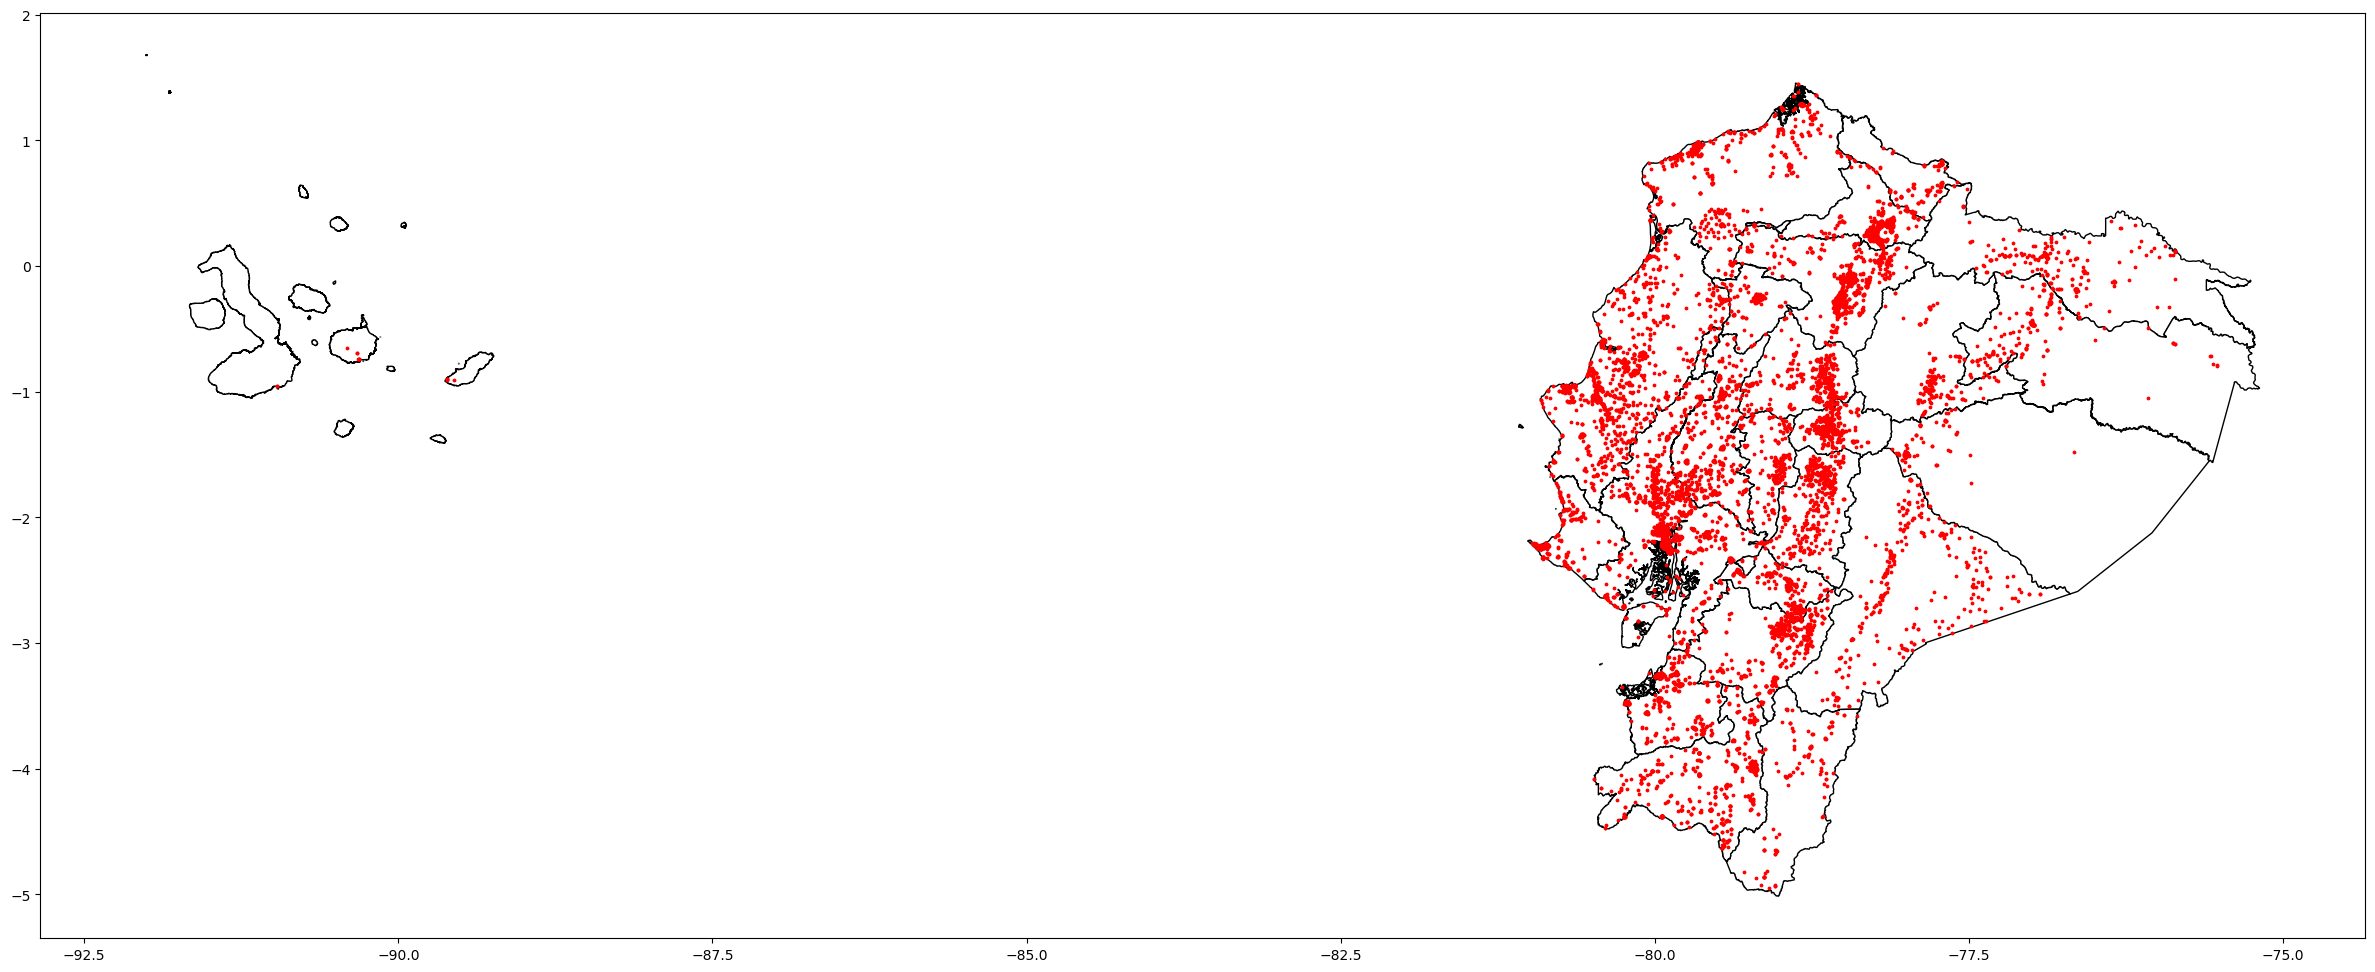

In [19]:


fig, ax = plt.subplots()

# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')

df_prov.plot(ax=ax, color='white', edgecolor='black')
df_MIES_c_gdf.plot(ax=ax, marker='o', color='red', markersize=3)

plt.show()



Distabcia entre bonos de 1000 días y los CDI 

In [20]:
df_mies_CDI=df_MIES_c_gdf[ df_MIES_c_gdf["servicio"] == "DESARROLLO INFANTIL INTEGRAL" ]
df_mies_CDI.dropna(subset='servicio',inplace= True)
df_mies_CDI.head()

,zp,dd_mies,ud_mies,dpa_desrov,dpa_prov,dpa_descan,dpa_canton,dpa_despar,dpa_parroq,region,...,no_rs_2018,ext_pob,pob,no_pob,tipo,descr_tipo,corte,wgs_x,wgs_y,geometry
0,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,GONZÁLEZ SUÁREZ,40101,Sierra,...,20.0,3.0,14.0,14.0,intramural,modalidad que opera en centros de atención,Julio_2022,-77.715036,0.831716,POINT (-77.71504 0.83172)
2,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,GONZÁLEZ SUÁREZ,40101,Sierra,...,13.0,10.0,12.0,10.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-77.710690,0.835217,POINT (-77.71069 0.83522)
6,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,TULCÁN,40102,Sierra,...,16.0,6.0,13.0,11.0,intramural,modalidad que opera en centros de atención,Julio_2022,-77.738799,0.793285,POINT (-77.73880 0.79329)
7,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,TULCÁN,40102,Sierra,...,38.0,5.0,31.0,26.0,intramural,modalidad que opera en centros de atención,Julio_2022,-77.723189,0.811346,POINT (-77.72319 0.81135)
10,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,TULCÁN,40102,Sierra,...,24.0,3.0,15.0,20.0,intramural,modalidad que opera en centros de atención,Julio_2022,-77.724087,0.806532,POINT (-77.72409 0.80653)


In [30]:
df_final_1000=df_final[ df_final["beneficio"] == "BONO 1000 DIAS" ]
df_final_1000.dropna(subset='geometry',inplace= True)
df_final_1000.head()

,DPA_PROVIN,DPA_DESPRO,beneficio,edad,geometry
21980,01,AZUAY,BONO 1000 DIAS,40.0,POINT (-79.03046 -2.87605)
22940,01,AZUAY,BONO 1000 DIAS,40.0,POINT (-79.07512 -2.86861)
26152,16,PASTAZA,BONO 1000 DIAS,27.0,POINT (-77.99862 -1.51087)
28128,03,CAÃAR,BONO 1000 DIAS,23.0,POINT (-78.92599 -2.50522)
28167,01,AZUAY,BONO 1000 DIAS,36.0,POINT (-78.75697 -2.79987)


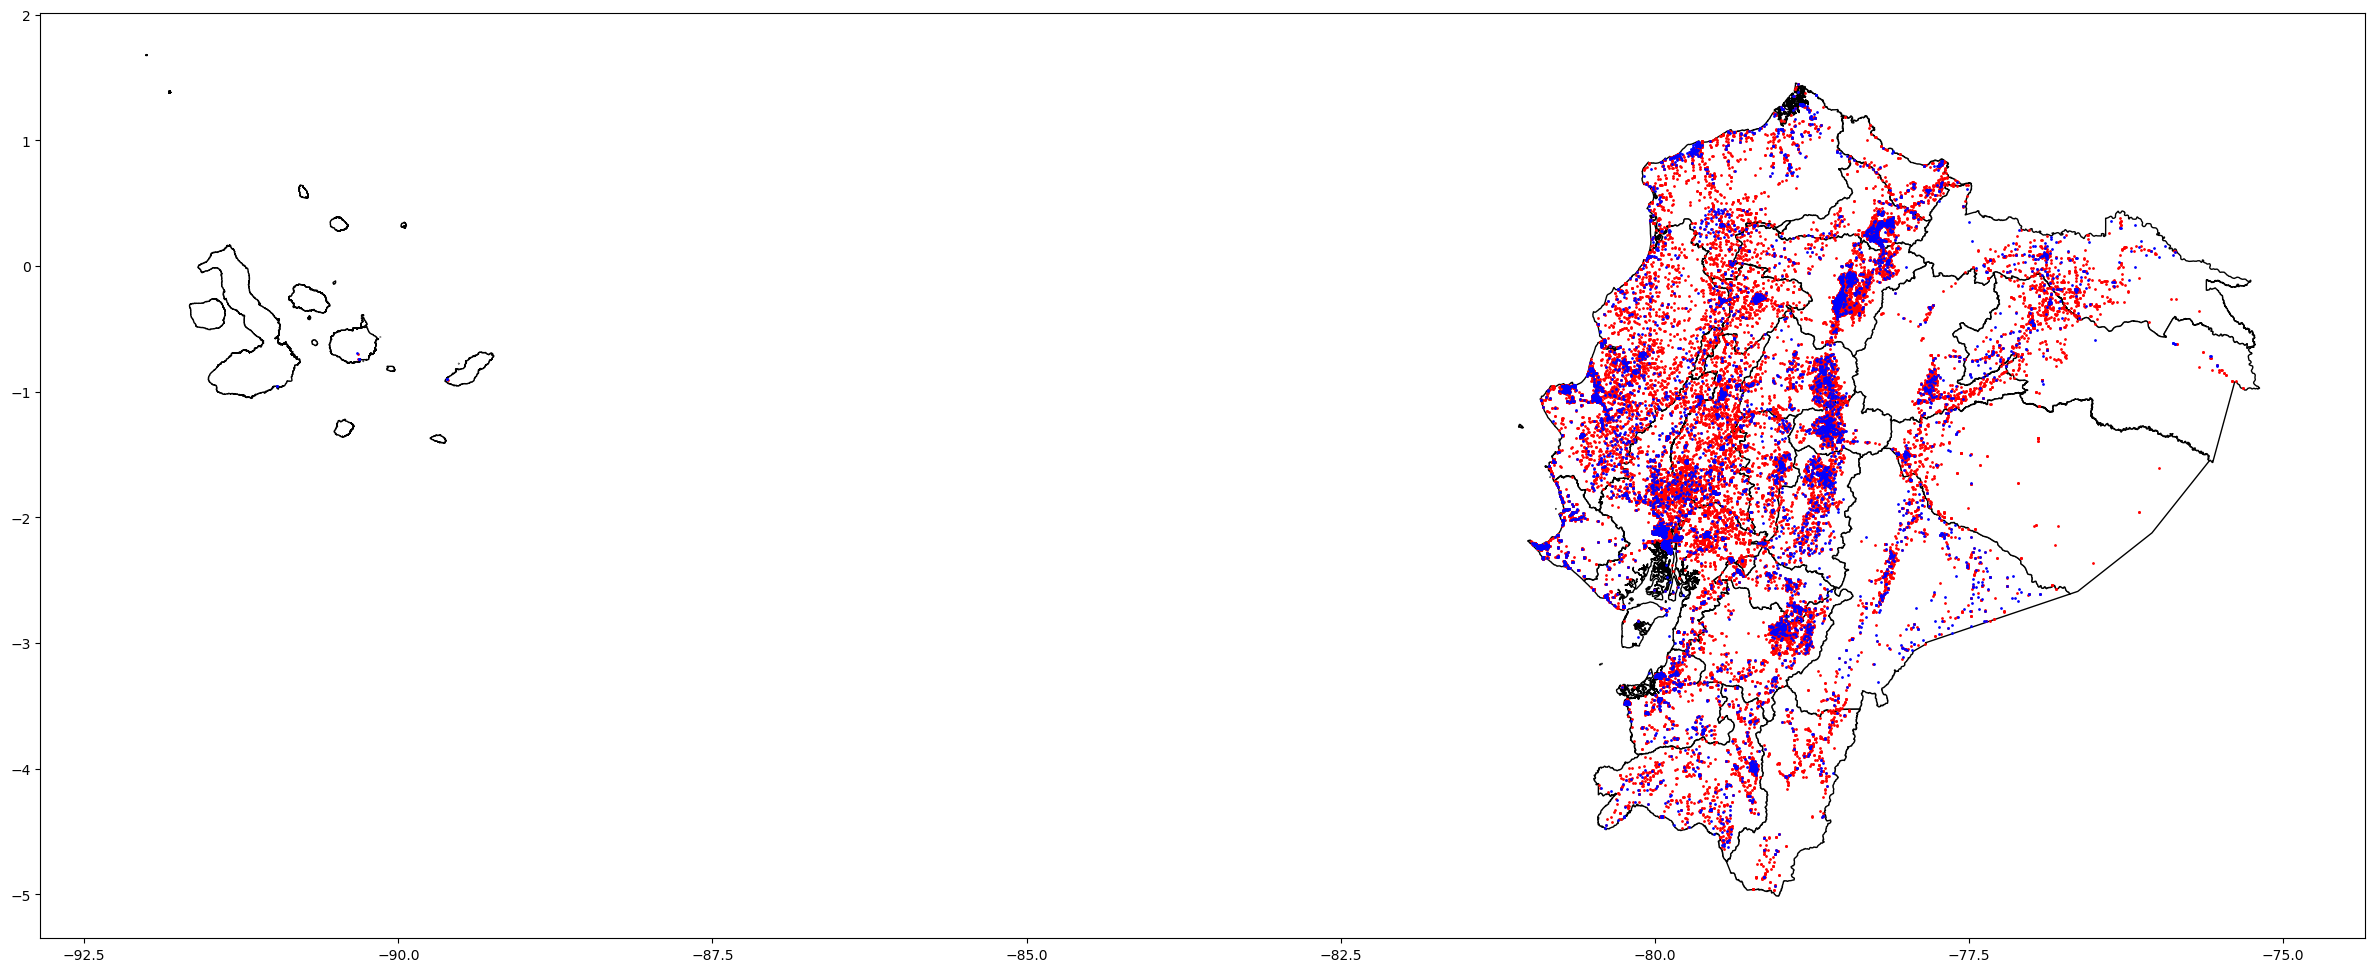

In [31]:


fig, ax = plt.subplots()

ax.set_aspect('equal')

df_prov.plot(ax=ax, color='white', edgecolor='black')
df_final_1000.plot(ax=ax, marker='o', color='red', markersize=1)
df_mies_CDI.plot(ax=ax, marker='o', color='blue', markersize=1)
plt.show()


In [32]:
from sklearn.neighbors import BallTree


def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

In [33]:
df_final_1000.reset_index(inplace=True)

In [42]:
df_mies_CDI.dropna(subset='wgs_x',inplace= True)
df_final_1000.dropna(subset='geometry',inplace= True)

In [43]:
df_mies_CDI

,zp,dd_mies,ud_mies,dpa_desrov,dpa_prov,dpa_descan,dpa_canton,dpa_despar,dpa_parroq,region,...,no_rs_2018,ext_pob,pob,no_pob,tipo,descr_tipo,corte,wgs_x,wgs_y,geometry
0,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,GONZÁLEZ SUÁREZ,40101,Sierra,...,20.0,3.0,14.0,14.0,intramural,modalidad que opera en centros de atención,Julio_2022,-77.715036,0.831716,POINT (-77.71504 0.83172)
2,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,GONZÁLEZ SUÁREZ,40101,Sierra,...,13.0,10.0,12.0,10.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-77.710690,0.835217,POINT (-77.71069 0.83522)
6,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,TULCÁN,40102,Sierra,...,16.0,6.0,13.0,11.0,intramural,modalidad que opera en centros de atención,Julio_2022,-77.738799,0.793285,POINT (-77.73880 0.79329)
7,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,TULCÁN,40102,Sierra,...,38.0,5.0,31.0,26.0,intramural,modalidad que opera en centros de atención,Julio_2022,-77.723189,0.811346,POINT (-77.72319 0.81135)
10,Zona Planificación 1,04D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A TULCAN,CARCHI,4,TULCAN,401,TULCÁN,40102,Sierra,...,24.0,3.0,15.0,20.0,intramural,modalidad que opera en centros de atención,Julio_2022,-77.724087,0.806532,POINT (-77.72409 0.80653)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10828,Zona Planificación: Quito,17D09,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,TUMBACO,170184,Sierra,...,27.0,NaN,8.0,8.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-78.405097,-0.212754,POINT (-78.40510 -0.21275)
10829,Zona Planificación: Quito,17D09,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,TUMBACO,170184,Sierra,...,19.0,2.0,10.0,13.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-78.376080,-0.210950,POINT (-78.37608 -0.21095)
10837,Zona Planificación: Quito,17D09,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,YARUQUI,170185,Sierra,...,8.0,2.0,14.0,12.0,intramural,modalidad que opera en centros de atención,Julio_2022,-78.308165,-0.166376,POINT (-78.30817 -0.16638)
10838,Zona Planificación: Quito,17D09,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO C...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,YARUQUI,170185,Sierra,...,15.0,3.0,10.0,1.0,intramural,modalidad que opera en centros de atención,Julio_2022,-78.347989,-0.108541,POINT (-78.34799 -0.10854)


In [44]:
# Find closest public transport stop for each building and get also the distance based on haversine distance
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric
# but useful as we get the distance between points in meters
closest_MIES = nearest_neighbor(df_final_1000, df_mies_CDI, return_dist=True)
closest_MIES

,zp,dd_mies,ud_mies,dpa_desrov,dpa_prov,dpa_descan,dpa_canton,dpa_despar,dpa_parroq,region,...,ext_pob,pob,no_pob,tipo,descr_tipo,corte,wgs_x,wgs_y,geometry,distance
0,Zona Planificación 6,01D02,UNIDAD DESCONCENTRADA ZONAL 6,AZUAY,1,CUENCA,101,EL BATÁN,10103,Sierra,...,1.0,4.0,6.0,intramural,modalidad que opera en centros de atención,Julio_2022,-79.031790,-2.901003,POINT (-79.03179 -2.90100),548.068828
1,Zona Planificación 6,01D01,UNIDAD DESCONCENTRADA ZONAL 6,AZUAY,1,CUENCA,101,SAYAUSI,10165,Sierra,...,4.0,22.0,6.0,intramural,modalidad que opera en centros de atención,Julio_2022,-79.072859,-2.873921,POINT (-79.07286 -2.87392),275.246883
2,Zona Planificación 3,16D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A PASTAZA,PASTAZA,16,PASTAZA,1601,PUYO,160150,Amazonía,...,14.0,14.0,5.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-77.997380,-1.498366,POINT (-77.99738 -1.49837),320.223041
3,Zona Planificación 6,03D02,UNIDAD DESCONCENTRADA DISTRITAL TIPO A AZOGUES,CAÑAR,3,EL TAMBO,305,EL TAMBO,30550,Sierra,...,9.0,12.0,11.0,intramural,modalidad que opera en centros de atención,Julio_2022,-78.925437,-2.504610,POINT (-78.92544 -2.50461),63.091181
4,Zona Planificación 6,01D06,UNIDAD DESCONCENTRADA DISTRITAL TIPO A GUALACEO,AZUAY,1,PAUTE,105,PAUTE,10550,Sierra,...,3.0,10.0,5.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-78.756136,-2.779387,POINT (-78.75614 -2.77939),453.657229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40781,Zona Planificación 5,24D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A SALINAS,SANTA ELENA,24,SANTA ELENA,2401,SAN JOSE DE ANCON,240156,Costa,...,9.0,25.0,7.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-80.857052,-2.286508,POINT (-80.85705 -2.28651),176.884507
40782,Zona Planificación 5,24D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A SALINAS,SANTA ELENA,24,SANTA ELENA,2401,SIMON BOLIVAR (JULIO MORENO),240155,Costa,...,11.0,22.0,5.0,intramural,modalidad que opera en centros de atención,Julio_2022,-80.362410,-2.186281,POINT (-80.36241 -2.18628),378.870818
40783,Zona Planificación 4,13D03,UNIDAD DESCONCENTRADA ZONAL 4,MANABI,13,JIPIJAPA,1306,DOCTOR MIGUEL MORÁN LUCIO,130601,Costa,...,2.0,11.0,15.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-80.582232,-1.338385,POINT (-80.58223 -1.33838),221.572178
40784,Zona Planificación: Quito,17D02,UNIDAD DESCONCENTRADA DISTRITAL TIPO B QUITO N...,PICHINCHA,17,DISTRITO METROPOLITANO DE QUITO,1701,CALDERON (CARAPUNGO),170155,Sierra,...,NaN,7.0,11.0,intramural,modalidad que opera en centros de atención,Julio_2022,-78.412468,-0.079417,POINT (-78.41247 -0.07942),153.557172


In [45]:
# Rename the geometry of closest stops gdf so that we can easily identify it
closest_MIES = closest_MIES.rename(columns={'geometry': 'closest_MIES_geom'})
closest_MIES = closest_MIES.rename(columns={'key': 'key2'})

In [46]:
# Merge the datasets by index (for this, it is good to use '.join()' -function)
CloseMIES = df_final_1000.join(closest_MIES)
CloseMIES.head()

,index,DPA_PROVIN,DPA_DESPRO,beneficio,edad,geometry,zp,dd_mies,ud_mies,dpa_desrov,...,ext_pob,pob,no_pob,tipo,descr_tipo,corte,wgs_x,wgs_y,closest_MIES_geom,distance
0,21980,01,AZUAY,BONO 1000 DIAS,40.0,POINT (-79.03046 -2.87605),Zona Planificación 6,01D02,UNIDAD DESCONCENTRADA ZONAL 6,AZUAY,...,1.0,4.0,6.0,intramural,modalidad que opera en centros de atención,Julio_2022,-79.031790,-2.901003,POINT (-79.03179 -2.90100),548.068828
1,22940,01,AZUAY,BONO 1000 DIAS,40.0,POINT (-79.07512 -2.86861),Zona Planificación 6,01D01,UNIDAD DESCONCENTRADA ZONAL 6,AZUAY,...,4.0,22.0,6.0,intramural,modalidad que opera en centros de atención,Julio_2022,-79.072859,-2.873921,POINT (-79.07286 -2.87392),275.246883
2,26152,16,PASTAZA,BONO 1000 DIAS,27.0,POINT (-77.99862 -1.51087),Zona Planificación 3,16D01,UNIDAD DESCONCENTRADA DISTRITAL TIPO A PASTAZA,PASTAZA,...,14.0,14.0,5.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-77.997380,-1.498366,POINT (-77.99738 -1.49837),320.223041
3,28128,03,CAÃAR,BONO 1000 DIAS,23.0,POINT (-78.92599 -2.50522),Zona Planificación 6,03D02,UNIDAD DESCONCENTRADA DISTRITAL TIPO A AZOGUES,CAÑAR,...,9.0,12.0,11.0,intramural,modalidad que opera en centros de atención,Julio_2022,-78.925437,-2.504610,POINT (-78.92544 -2.50461),63.091181
4,28167,01,AZUAY,BONO 1000 DIAS,36.0,POINT (-78.75697 -2.79987),Zona Planificación 6,01D06,UNIDAD DESCONCENTRADA DISTRITAL TIPO A GUALACEO,AZUAY,...,3.0,10.0,5.0,extramural,modalidad que opera mediante visitas domicilia...,Julio_2022,-78.756136,-2.779387,POINT (-78.75614 -2.77939),453.657229


In [52]:
CloseMIES['distance'].mean()

584.1092782144576